In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
from scipy.sparse import hstack
from xgboost import XGBClassifier
from datetime import datetime


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/task_dataset.csv")

print(" file successfully found")

 file successfully found


Dataset Shape: (300, 16)

Missing Values:
 Task ID                      0
Task Description             0
Deadline                     0
Priority                     0
Assigned User                0
User Workload                0
Past Task Behavior           0
Category                     0
Status                       0
Time Taken (hours)           0
Days Remaining               0
User Current Load            0
Past Behavior Score          0
Task Complexity Score        0
Category Specialist Match    0
User Availability Flag       0
dtype: int64


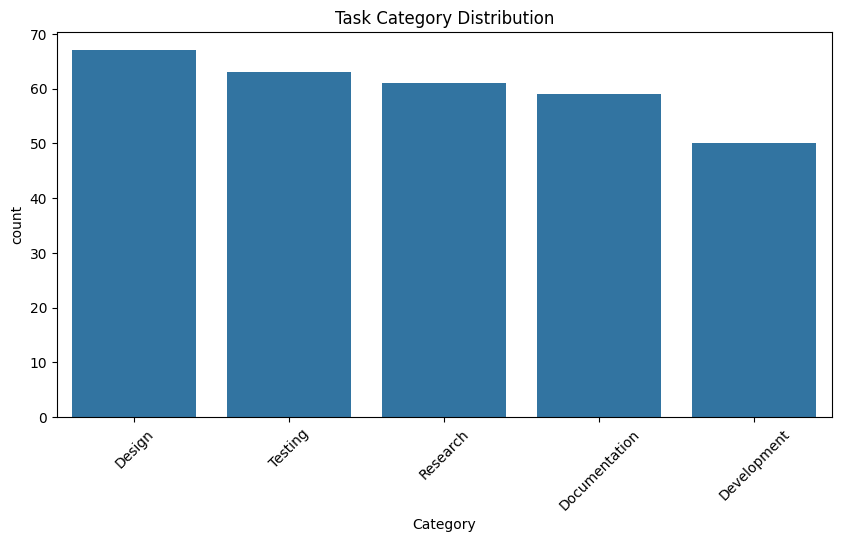

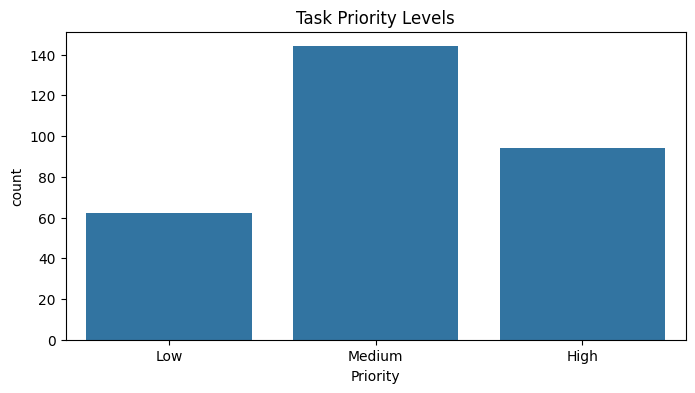

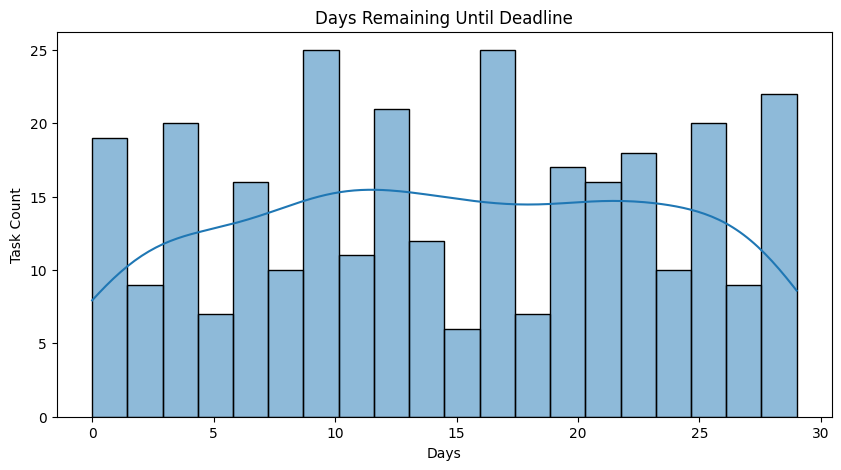

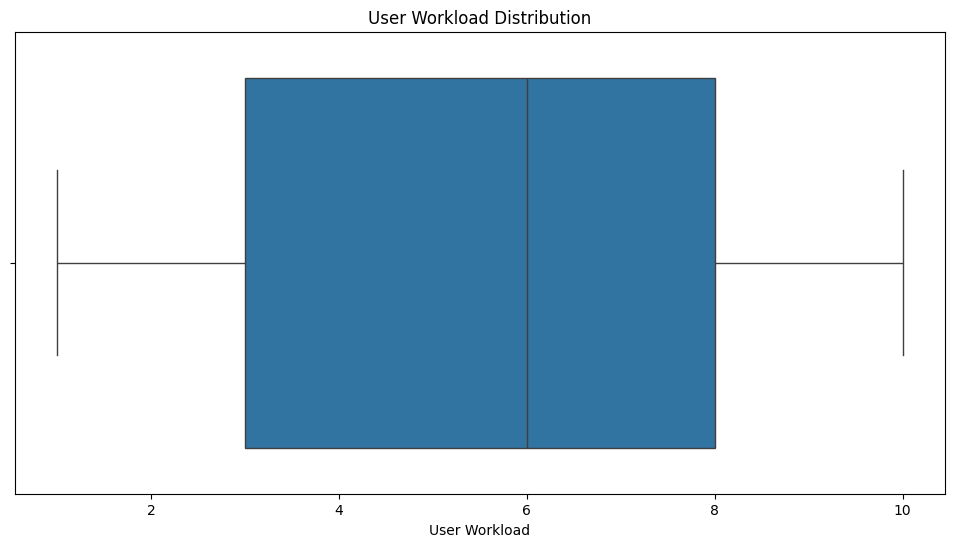

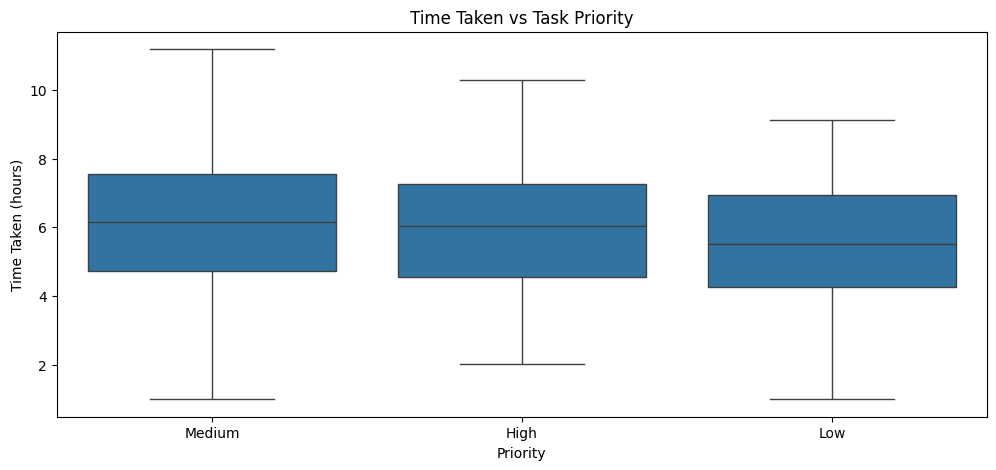

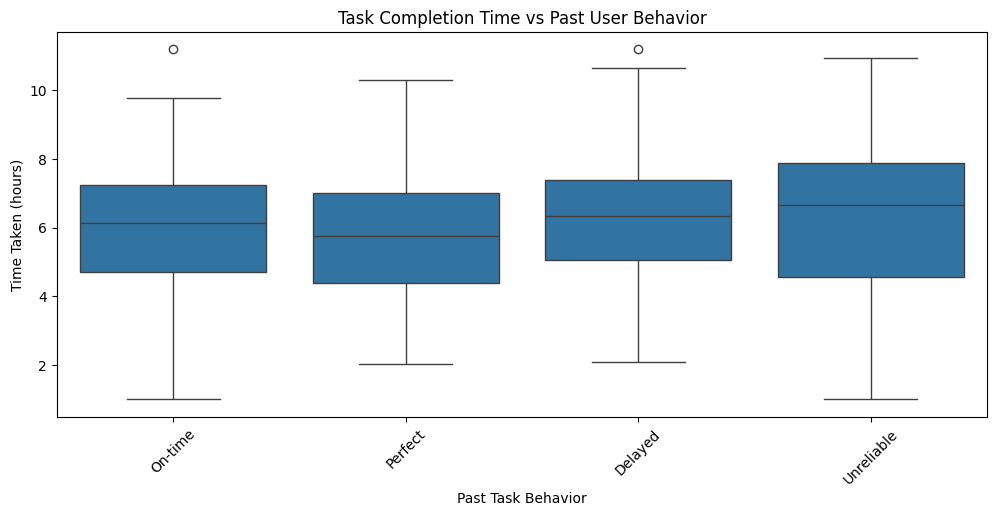

EDA completed successfully!


In [ ]:
# Dataset
df = pd.read_csv("/content/drive/MyDrive/task_dataset.csv")
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

# Standardizing Dates
df["Deadline"] = pd.to_datetime(df["Deadline"], errors="coerce")
df["Days Remaining"] = (df["Deadline"] - pd.to_datetime("today")).dt.days

# Handling Missing Values
df.fillna({"Priority": "Medium", "Status": "Open", "Time Taken (hours)": df["Time Taken (hours)"].median()}, inplace=True)

# Normalizing Priority Levels
priority_mapping = {"Low": 1, "Medium": 2, "High": 3}
df["Priority_Score"] = df["Priority"].map(priority_mapping)


# Handling Outliers in Time Taken
q1 = df["Time Taken (hours)"].quantile(0.25)
q3 = df["Time Taken (hours)"].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
df["Time Taken (hours)"] = np.where(df["Time Taken (hours)"] > upper_bound, upper_bound, df["Time Taken (hours)"])

# --- EDA Visualizations ---
# Task Category Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Category", order=df["Category"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Task Category Distribution")
plt.show()

# Priority Level Distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="Priority", order=["Low", "Medium", "High"])
plt.title("Task Priority Levels")
plt.show()

# Deadline Analysis
plt.figure(figsize=(10, 5))
sns.histplot(df["Days Remaining"], bins=20, kde=True)
plt.title("Days Remaining Until Deadline")
plt.xlabel("Days")
plt.ylabel("Task Count")
plt.show()

# User Workload Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="User Workload")
plt.title("User Workload Distribution")
plt.show()

# Task Completion Behavior
plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x="Priority", y="Time Taken (hours)")
plt.title("Time Taken vs Task Priority")
plt.show()

# Past Task Behavior Impact on Completion Time
plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x="Past Task Behavior", y="Time Taken (hours)")
plt.title("Task Completion Time vs Past User Behavior")
plt.xticks(rotation=45)
plt.show()

print("EDA completed successfully!")

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming df is your original DataFrame with columns:
# ["Priority", "Category", "Time Taken (hours)", "Days Remaining", "Assigned User"]

# Drop missing values
df_ml = df[["Priority", "Category", "Time Taken (hours)", "Days Remaining", "Assigned User"]].dropna().copy()

# -- Feature Engineering --

# Map Priority to numeric Task Complexity (simple)
priority_map = {"Low": 1, "Medium": 2, "High": 3}
df_ml["Task_Complexity"] = df_ml["Priority"].map(priority_map)

# Compute User Workload (number of tasks currently assigned)
user_workload = df_ml["Assigned User"].value_counts().to_dict()
df_ml["User_Workload"] = df_ml["Assigned User"].map(user_workload)

# Label encode categorical features
le_priority = LabelEncoder()
le_cat = LabelEncoder()
le_user = LabelEncoder()

df_ml["Priority_Encoded"] = le_priority.fit_transform(df_ml["Priority"])
df_ml["Category_Encoded"] = le_cat.fit_transform(df_ml["Category"])
df_ml["User_Encoded"] = le_user.fit_transform(df_ml["Assigned User"])

# Features and target
feature_cols = ["Priority_Encoded", "Category_Encoded", "Time Taken (hours)", "Days Remaining", "Task_Complexity", "User_Workload"]
X = df_ml[feature_cols]
y = df_ml["User_Encoded"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest with hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

# Predictions and accuracy
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Best RF params: {grid_search.best_params_}")
print(f"Assignment Prediction Accuracy: {accuracy:.4f}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Assignment Prediction Accuracy: 1.0000


In [ ]:
# Force remove corrupted punkt and re-download
nltk.download('punkt', force=True)
nltk.download('stopwords')

# Download the missing 'punkt_tab' resource
nltk.download('punkt_tab', force=True)# Preprocessing
df["Cleaned_Description"] = df["Task Description"].str.lower()
df["Cleaned_Description"] = df["Cleaned_Description"].str.translate(str.maketrans("", "", string.punctuation))

# Tokenization
df["Tokens"] = df["Cleaned_Description"].apply(word_tokenize)

# Stopword removal
stop_words = set(stopwords.words("english"))
df["Tokens"] = df["Tokens"].apply(lambda x: [word for word in x if word not in stop_words])

# Stemming
stemmer = PorterStemmer()
df["Tokens"] = df["Tokens"].apply(lambda x: [stemmer.stem(word) for word in x])

# Join tokens for TF-IDF
df["Processed_Description"] = df["Tokens"].apply(lambda x: " ".join(x))


# Vectorize the Processed Task Descriptions
vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features
X = vectorizer.fit_transform(df["Processed_Description"]).toarray()

# Target variable (you can change 'Category' to 'Priority' or other target field)
y = df["Category"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_preds))
print("Accuracy:", accuracy_score(y_test, nb_preds))

# Support Vector Machine (SVM)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

print("\nSVM Classification Report:")
print(classification_report(y_test, svm_preds))
print("Accuracy:", accuracy_score(y_test, svm_preds))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.19      0.27        16
           1       0.05      0.20      0.08         5
           2       1.00      0.14      0.25        14
           3       0.25      0.38      0.30        13
           4       0.15      0.17      0.16        12

    accuracy                           0.22        60
   macro avg       0.39      0.22      0.21        60
weighted avg       0.46      0.22      0.24        60

Accuracy: 0.21666666666666667

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.38      0.28        16
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00        14
           3       0.20      0.08      0.11        13
           4       0.10      0.17      0.12        12

    accuracy                           0.15        60
   macro avg       0.10      0.12     

In [ ]:
# Clean your text column
df["Cleaned_Description"] = df["Task Description"].str.lower().str.replace(r'[^a-z\s]', '', regex=True)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df["Cleaned_Description"]).toarray()

# Target: Priority
y = df["Priority"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Predict
y_pred = rfc.predict(X_test)

# Evaluation
print("Random Forest Priority Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Random Forest Priority Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        19
         Low       0.00      0.00      0.00        14
      Medium       0.45      1.00      0.62        27

    accuracy                           0.45        60
   macro avg       0.15      0.33      0.21        60
weighted avg       0.20      0.45      0.28        60

Accuracy: 0.45


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Define param grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# GridSearch
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Accuracy Score:", grid.best_score_)

# Count tasks assigned to each user
user_workload = df["User Workload"].value_counts()

# Find user with lowest workload
least_busy_user = user_workload.idxmin()

print(f"Next task should be assigned to: {least_busy_user}")




Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Accuracy Score: 0.4875
Next task should be assigned to: 4


In [ ]:
# Select features and target for priority prediction
features = ["Time Taken (hours)", "User Workload", "Past Task Behavior"]
df = df.dropna(subset=features + ["Priority"])
X = pd.get_dummies(df[features])  # Convert categorical to numeric if needed
y = df["Priority"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# GridSearchCV for hyperparameter tuning
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

        High       0.38      0.26      0.31        19
         Low       0.17      0.07      0.10        14
      Medium       0.46      0.70      0.56        27

    accuracy                           0.42        60
   macro avg       0.34      0.35      0.32        60
weighted avg       0.37      0.42      0.37        60

Accuracy: 0.4166666666666667


In [ ]:
import pandas as pd
from datetime import datetime

# Step 1: Convert Deadline to datetime if not already
df["Deadline"] = pd.to_datetime(df["Deadline"], errors='coerce')

# Step 2: Calculate days remaining from today
today = pd.to_datetime("today")
df["Days Remaining"] = (df["Deadline"] - today).dt.days

# Step 3: Map textual Priority to score
priority_mapping = {"High": 3, "Medium": 2, "Low": 1}
df["Priority_Score"] = df["Priority"].map(priority_mapping).fillna(1)

# Step 4: Define urgency score: priority + deadline
df["Urgency Score"] = (
    df["Priority_Score"] * 2 +
    df["Days Remaining"].apply(lambda x: 5 if x <= 2 else 2 if x <= 7 else 0)
)

# Step 5: Sort by most urgent
df_sorted = df.sort_values(by="Urgency Score", ascending=False).copy()

# Step 6: Get unique users and simulate initial workload
users = df_sorted["Assigned User"].dropna().unique()
user_workload_map = {
    user: df_sorted[df_sorted["Assigned User"] == user]["User Workload"].iloc[0]
    for user in users
}

# Default max workload (in hours)
MAX_WORKLOAD = 40

# Step 7: Reassign tasks based on lowest current workload
assigned_users = []
for _, row in df_sorted.iterrows():
    # Choose user with least workload
    least_busy_user = min(user_workload_map, key=user_workload_map.get)
    assigned_users.append(least_busy_user)

    # Update workload with this task
    user_workload_map[least_busy_user] += row["Time Taken (hours)"]

# Step 8: Save final assignment
df_sorted["Final Assigned User"] = assigned_users

# Step 9: Show some results
print(df_sorted[[
    "Task ID", "Task Description", "Priority", "Deadline", "Days Remaining",
    "Time Taken (hours)", "Urgency Score", "Final Assigned User"
]].head(10))


      Task ID      Task Description Priority   Deadline  Days Remaining  \
249  TASK0250  Task description 250     High 2025-05-29               1   
156  TASK0157  Task description 157     High 2025-05-28               0   
84   TASK0085   Task description 85     High 2025-05-29               1   
162  TASK0163  Task description 163     High 2025-05-30               2   
241  TASK0242  Task description 242     High 2025-05-28               0   
270  TASK0271  Task description 271   Medium 2025-05-28               0   
181  TASK0182  Task description 182   Medium 2025-05-28               0   
147  TASK0148  Task description 148   Medium 2025-05-28               0   
282  TASK0283  Task description 283   Medium 2025-05-28               0   
279  TASK0280  Task description 280   Medium 2025-05-28               0   

     Time Taken (hours)  Urgency Score Final Assigned User  
249                6.81             11                 Eva  
156                9.73             11             C

<Axes: title={'center': 'Final Workload Distribution'}>

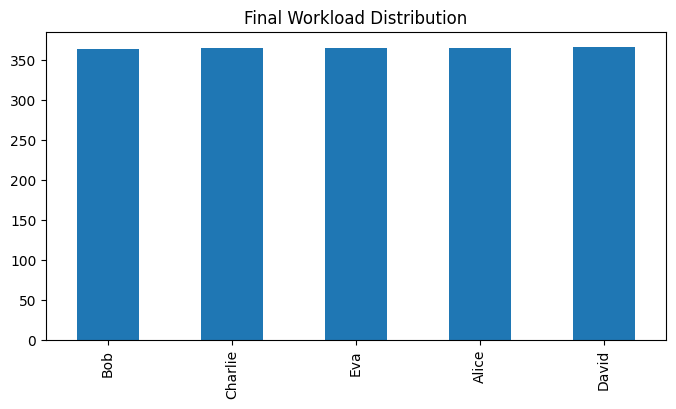

In [ ]:
# Visualize total workload per user after new assignment
final_workload_df = pd.DataFrame.from_dict(
    user_workload_map, orient='index', columns=["Final Workload (hrs)"]
)
final_workload_df.sort_values("Final Workload (hrs)").plot(
    kind='bar', figsize=(8,4), legend=False, title="Final Workload Distribution"
)


In [ ]:
# Heuristic Rule-Based Task Assignment Based on Workload and Urgency

priority_map = {"High": 3, "Medium": 2, "Low": 1}
df["Priority_Score"] = df["Priority"].map(priority_map).fillna(1)

df["Urgency"] = df["Priority_Score"] * 2 + df["Days Remaining"].apply(lambda x: 5 if x <= 2 else 2 if x <= 7 else 0)

df_sorted = df.sort_values("Urgency", ascending=False).copy()

users = df["Assigned User"].dropna().unique()
user_workload_map = {
    user: df[df["Assigned User"] == user]["User Workload"].iloc[0]
    for user in users
}

assigned_users = []
for _, row in df_sorted.iterrows():
    eligible_users = sorted(user_workload_map.items(), key=lambda x: x[1])
    chosen_user = eligible_users[0][0]
    assigned_users.append(chosen_user)
    user_workload_map[chosen_user] += row["Time Taken (hours)"]

df_sorted["Heuristic Assigned User"] = assigned_users
df_sorted[["Task ID", "Task Description", "Urgency", "Heuristic Assigned User"]].head()


,Task ID,Task Description,Urgency,Heuristic Assigned User
249,TASK0250,Task description 250,11,Bob
156,TASK0157,Task description 157,11,Charlie
84,TASK0085,Task description 85,11,Eva
162,TASK0163,Task description 163,11,Alice
241,TASK0242,Task description 242,11,David


In [ ]:
# ML-Based Task Assignment Using Random Forest
# Encode categorical columns
le_priority = LabelEncoder()
le_category = LabelEncoder()
le_user = LabelEncoder()

df["Priority_Encoded"] = le_priority.fit_transform(df["Priority"])
df["Category_Encoded"] = le_category.fit_transform(df["Category"])
df["Assigned_User_Encoded"] = le_user.fit_transform(df["Assigned User"])

# Define features based on your columns
features = [
    "Priority_Encoded", "Category_Encoded", "Time Taken (hours)",
    "Days Remaining", "User Current Load", "Past Behavior Score",
    "Task Complexity Score", "Category Specialist Match", "User Availability Flag"
]

X = df[features]
y = df["Assigned_User_Encoded"]

# Train-test split with fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest with balanced class weight to handle class imbalance
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

print(f"✅ Improved Assignment Prediction Accuracy: {accuracy:.4f}")
print("📊 Updated Classification Report:\n", report)


✅ Improved Assignment Prediction Accuracy: 0.4333
📊 Updated Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.44      0.45        16
           1       0.14      0.20      0.17         5
           2       0.53      0.71      0.61        14
           3       0.67      0.31      0.42        13
           4       0.31      0.33      0.32        12

    accuracy                           0.43        60
   macro avg       0.42      0.40      0.39        60
weighted avg       0.47      0.43      0.43        60



In [ ]:
import joblib

joblib.dump(rf, "rf_model.joblib")
joblib.dump(le_user, "le_user.joblib")
joblib.dump(le_priority, "le_priority.joblib")
joblib.dump(le_category, "le_category.joblib")



['le_category.joblib']

In [ ]:
import streamlit as st
import pandas as pd
import joblib

# Load trained model and encoders
rf_model = joblib.load("rf_model.joblib")
le_user = joblib.load("le_user.joblib")
le_priority = joblib.load("le_priority.joblib")
le_category = joblib.load("le_category.joblib")

st.set_page_config(page_title="🧠 Task Assignment Predictor", layout="wide")

st.title("🔮 Intelligent Task Assignment Predictor")
st.markdown("Upload your task details and get predicted user assignment based on workload, task complexity, urgency, and behavior.")

# Upload CSV file
uploaded_file = st.file_uploader("📂 Upload your task CSV file", type=["csv"])

if uploaded_file:
    input_df = pd.read_csv(uploaded_file)

    # Encode priority and category
    input_df["Priority_Encoded"] = le_priority.transform(input_df["Priority"])
    input_df["Category_Encoded"] = le_category.transform(input_df["Category"])

    # Features expected by model
    expected_features = [
        "Priority_Encoded", "Category_Encoded", "Time Taken (hours)",
        "Days Remaining", "User Current Load", "Past Behavior Score",
        "Task Complexity Score"
    ]

    # Check for missing features
    missing_features = [f for f in expected_features if f not in input_df.columns]
    if missing_features:
        st.error(f"Missing columns in uploaded data: {missing_features}")
    else:
        X_input = input_df[expected_features]

        # Predict assigned user
        y_pred = rf_model.predict(X_input)
        y_pred_labels = le_user.inverse_transform(y_pred)

        # Add predictions to DataFrame
        input_df["Predicted Assigned User"] = y_pred_labels

        st.success("✅ Prediction completed!")
        st.dataframe(input_df)

        csv = input_df.to_csv(index=False).encode('utf-8')
        st.download_button("📥 Download Prediction Results", csv, "predictions.csv", "text/csv")

else:
    st.info("👆 Upload a task CSV file to begin prediction.")


2025-05-27 09:47:50.318 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 09:47:50.322 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 09:47:50.324 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 09:47:50.325 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 09:47:50.326 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 09:47:50.327 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 09:47:50.328 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 09:47:50.328 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
streamlit_code = """
import streamlit as st
import pandas as pd
import joblib

# Load trained model and encoders
rf_model = joblib.load("rf_model.joblib")
le_user = joblib.load("le_user.joblib")
le_priority = joblib.load("le_priority.joblib")
le_category = joblib.load("le_category.joblib")

st.set_page_config(page_title="🧠 Task Assignment Predictor", layout="wide")

st.title("🔮 Intelligent Task Assignment Predictor")
st.markdown("Upload your task details and get predicted user assignment based on workload, task complexity, urgency, and behavior.")

# Upload CSV file
uploaded_file = st.file_uploader("📂 Upload your task CSV file", type=["csv"])

if uploaded_file:
    input_df = pd.read_csv(uploaded_file)

    # Encode priority and category
    input_df["Priority_Encoded"] = le_priority.transform(input_df["Priority"])
    input_df["Category_Encoded"] = le_category.transform(input_df["Category"])

    # Features expected by model
    expected_features = [
        "Priority_Encoded", "Category_Encoded", "Time Taken (hours)",
        "Days Remaining", "User Current Load", "Past Behavior Score",
        "Task Complexity Score"
    ]

    # Check for missing features
    missing_features = [f for f in expected_features if f not in input_df.columns]
    if missing_features:
        st.error(f"Missing columns in uploaded data: {missing_features}")
    else:
        X_input = input_df[expected_features]

        # Predict assigned user
        y_pred = rf_model.predict(X_input)
        y_pred_labels = le_user.inverse_transform(y_pred)

        # Add predictions to DataFrame
        input_df["Predicted Assigned User"] = y_pred_labels

        st.success("✅ Prediction completed!")
        st.dataframe(input_df)

        csv = input_df.to_csv(index=False).encode('utf-8')
        st.download_button("📥 Download Prediction Results", csv, "predictions.csv", "text/csv")

else:
    st.info("👆 Upload a task CSV file to begin prediction.")
"""

with open("streamlit_app.py", "w") as f:
    f.write(streamlit_code)

print("✅ streamlit_app.py file created successfully.")


✅ streamlit_app.py file created successfully.


In [ ]:
!streamlit run streamlit_app.py & npx localtunnel --port 8501




⠙⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.227.9.176:8501

⠦⠧your url is: https://silent-seals-speak.loca.lt
  Stopping...
^C
